# Predicting Life Expectancy - Enhancing Model Performance with Feature Selection

Feature selection is a crucial step in machine learning. It involves choosing the most relevant features, or predictors, to be used in building our model. The main objectives of feature selection are:

1. **Simplicity**: Fewer features simplify the model, making it easier to interpret.
2. **Efficiency**: Less features speed up model training, especially with large datasets.
3. **Overfitting Prevention**: Removing irrelevant features helps prevent overfitting.
4. **Accuracy**: Removing irrelevant features can sometimes improve model accuracy.
5. **Relevance**: Feature selection filters out noise, leading to more meaningful insights.
6. **Dimensionality Reduction**: Feature selection helps mitigate the "curse of dimensionality" in high-dimensional data.

In the context of predicting life expectancy, feature selection can assist us in identifying the most significant factors that influence life expectancy. For instance, is life expectancy more influenced by a country's GDP, its healthcare expenditure, or its education system? By selecting the appropriate features, we can construct a model that not only accurately predicts life expectancy but also provides us insights into what factors life expectancy depends on.

For more info see the following articles:

- https://medium.com/@h.jurza/mastering-feature-selection-elevate-your-machine-learning-game-a70a52b6f243

# Import packages

In [4]:
# General packages
import pandas as pd
import numpy as np

# Pre-processing and modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

# Set pandas to display all columns in a dataframe
pd.set_option('display.max_columns', None)

# Define Useful Functions

In [28]:
def format_dataframe_columns(df_in):
    """formats dataframe column names by removing spaces, special characters and makes lowercase"""

    import re

    def rename_col(old_col):
        # Make column str type and strip training and leading whitespace
        new_col = str(old_col).strip() 

        # Replace multiple spaces with a single space
        new_col = re.sub(r'\s+', ' ', new_col)

        # Replace spaces, hyphens and slashes with underscore
        new_col = new_col.replace(' ','_')
        new_col = new_col.replace('-','_')
        new_col = new_col.replace('/','_')
        new_col = new_col.replace('\\','_')

        # Remove special characters
        new_col = re.sub(r'[?*!&()]', '', new_col)

        # Make all lowercase
        new_col = new_col.lower()

        return new_col

    df_out = df_in.copy()

    # Get list of dataframe columns
    df_cols_old = df_out.columns

    # Make list of new col names, then put into replacement dict
    df_cols_new = [rename_col(old_col) for old_col in df_cols_old]
    replacement_dict = dict(zip(df_cols_old, df_cols_new))

    # Rename df cols with new col names
    df_out = df_out.rename(columns=(replacement_dict))

    return df_out

def preprocess_data(df, feature_variables, target_variable):
    """
    Preprocess the data: convert types, impute missing values, define target and feature variables, 
    one-hot encode categorical variables, and split the data into training and testing sets.

    Parameters:
    df (DataFrame): The original dataframe.
    feature_variables (list): The list of feature variables.
    target_variable (str): The target variable.

    Returns:
    X_train, X_test, y_train, y_test: Training and testing data.
    """
    # Convert the 'year' field from float to int
    df['year'] = df['year'].astype('int')

    # Update our categorical and numeric variable lists as we will use them later
    num_vars = df.select_dtypes(include=['float64', 'int64']).columns
    cat_vars = df.select_dtypes(include=['object']).columns

    # Impute missing values in categorical columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_vars] = cat_imputer.fit_transform(df[cat_vars])

    # Impute missing values in numerical columns
    num_imputer = SimpleImputer(strategy='mean')
    df[num_vars] = num_imputer.fit_transform(df[num_vars])

    # Split the data into features (X) and target (y)
    X = df[feature_variables]
    y = df[target_variable]

    # One-hot encode the 'status' feature
    X_encoded = pd.get_dummies(X, drop_first=False)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test
    
def calculate_metrics(y_test, y_pred):
    """
    Calculate and print the MAE, MSE, RMSE, and R-squared score of the model's predictions.

    Parameters:
    y_test (Series or array-like): The actual target values.
    y_pred (Series or array-like): The predicted target values.

    Returns:
    None
    """
    # Calculate the Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {round(mae, 2)}")
    print(f"MSE: {round(mse, 2)}")
    print(f"RMSE: {round(rmse, 2)}")
    print(f"R-squared: {round(r2, 3)}")

def plot_feature_importances(result):
    """
    Plot the feature importances of a trained model.

    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): The trained model.

    Returns:
    None
    """
    # Get the coefficients of the features
    coefficients = result.params

    # Create a dataframe of coefficients for easy viewing
    feature_importance = pd.DataFrame({'Feature': coefficients.index, 'Importance': coefficients.values})

    # Remove the 'const' feature
    feature_importance = feature_importance[feature_importance['Feature'] != 'const']

    # Sort the DataFrame by 'Importance' in descending order
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
    plt.show()

def plot_feature_importances2(model):
    """
    Plot the feature importances of a trained model.
    
    Parameters:
    model: A trained model
    
    Returns:
    None
    """
    # Get the coefficients of the features
    coefficients = model.coef_

    # Create a dataframe of coefficients for easy viewing
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})

    # Sort the dataframe by the absolute value of the importance
    feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)

    # Plot the dataframe
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature importances')
    plt.show()

# Read data

In [23]:
# Read data
df = pd.read_csv('data/Life Expectancy Data.csv')

# Format dataframe columns to be lowercase and separated by underscores (for visual consistency)
df = format_dataframe_columns(df)

# Specify target variable (this won't change for this exercise)
target_variable = 'life_expectancy'

# Define feature variables (this will be used for all examples except the first where you define them yourself)
feature_variables = [
    'year',
    'status', 
    'adult_mortality',
    'infant_deaths', 
    'alcohol', 
    'percentage_expenditure', 
    'hepatitis_b',
    'measles', 
    'bmi', 
    'under_five_deaths', 
    'polio', 
    'total_expenditure',
    'diphtheria',
    'hiv_aids',
    'gdp',
    'population',
    'thinness_1_19_years',
    'thinness_5_9_years',
    'income_composition_of_resources',
    'schooling'
    ]


# 1. Backward elimination and forward selection

Two common feature selection methods are:

**Backward Elimination**

This method starts with all features and iteratively removes the least significant one until model performance decreases. Steps are:

1. Choose a significance level (e.g., SL = 0.05).
2. Fit the model with all predictors.
3. If the predictor with the highest p-value > SL, go to the next step. Otherwise, the model is ready.
4. Remove the predictor.
5. Fit the model without this variable.
6. Repeat steps 3-5 until all predictors have a p-value <= SL.

**Forward Selection**

This method starts with no features and adds them one by one, each time choosing the one that most improves the model. Steps are:

1. Choose a significance level (e.g., SL = 0.05).
2. Fit all simple regression models and select the one with the lowest p-value.
3. Keep this variable and fit all models with one extra predictor.
4. If the predictor with the lowest p-value < SL, go to the next step. Otherwise, the model is ready.
5. Keep the predictor and repeat steps 3-4 until all predictors have a p-value >= SL.

Both methods aim to simplify models and prevent overfitting. They can yield different results, so it's often beneficial to try different feature selection methods for your specific use case.

## 1.1 Manual feature selection

Below is our regression model we developed in the previous notebook. 

- Experiment by commenting out specific features (based on their p-values) to see how they affect regression results. 
- Try both backward elimination and forward selection processes outlined above

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     582.9
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:40:05   Log-Likelihood:                -6635.1
No. Observations:                2350   AIC:                         1.331e+04
Df Residuals:                    2331   BIC:                         1.342e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

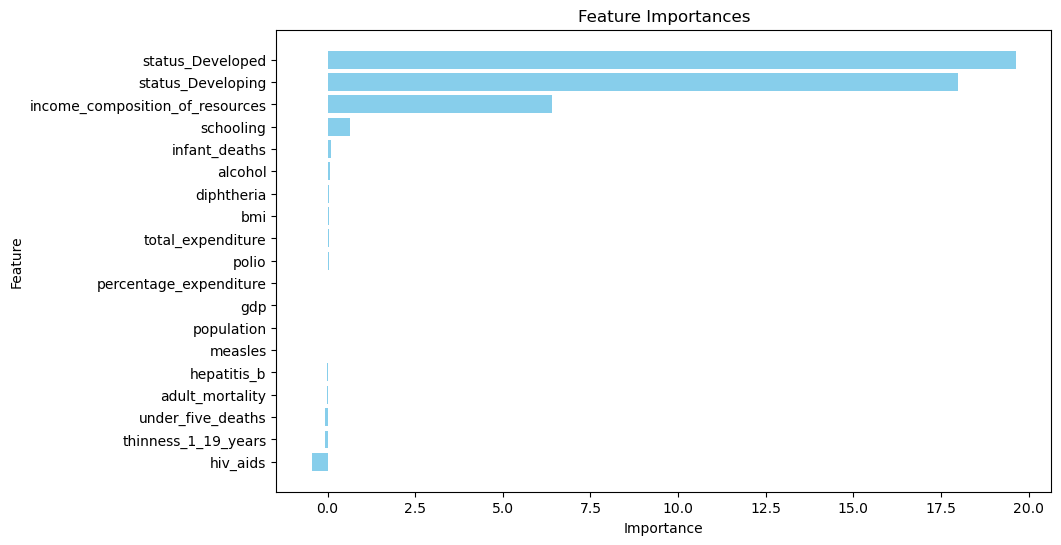

Variable with the highest p-value (over the significance level) is: 
population 	with p-value: 0.6950372656186445


In [26]:
# Define feature variables
# NOTE: Experiment here by commenting fields out to see how it affects the model

feature_variables_test = [
    'year',
    'status', 
    'adult_mortality',
    'infant_deaths', 
    'alcohol', 
    'percentage_expenditure', 
    'hepatitis_b',
    'measles', 
    'bmi', 
    'under_five_deaths', 
    'polio', 
    'total_expenditure',
    'diphtheria',
    'hiv_aids',
    'gdp',
    'population',
    'thinness_1_19_years',
    'thinness_5_9_years',
    'income_composition_of_resources',
    'schooling'
    ]

# Data Prep
#===================================

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables_test, 
    target_variable=target_variable
    )

# Linear Regression model using statsmodels
#============================================

# Perform the linear regression
# Add a constant term to the independent variable
model_sm = sm.OLS(y_train, sm.add_constant(X_train))
result = model_sm.fit()

# Make predictions
y_pred_sm = result.predict(sm.add_constant(X_test))

# Print out the statistics
print(result.summary())

# Calculate valiadation metrics using our custom function:
calculate_metrics(y_test, y_pred_sm)

# Plot feature importances using our custom function:
plot_feature_importances(result)

def get_highest_p_value(result, significance_level):
    
    # Get the summary table
    summary_table = result.summary2().tables[1]

    # Get the variable with the highest p-value
    highest_pvalue_variable = summary_table['P>|t|'].idxmax()
    highest_pvalue = summary_table['P>|t|'].max()

    # Check if the highest p-value is over the significance level
    if highest_pvalue > significance_level:
        print(f"Variable with the highest p-value (over the significance level) is: \n{highest_pvalue_variable} \twith p-value: {highest_pvalue}")
    else:
        print("No variable has a p-value over the significance level.")

get_highest_p_value(result=result, significance_level=0.05)

## 1.2 Note on feature selection:

When you remove features with high p-values from your model, you are essentially simplifying your model by reducing its complexity. This is based on the premise that those features are not statistically significant in predicting the target variable, as indicated by their high p-values.

However, removing these features can sometimes lead to a decrease in the R-squared value. The R-squared value is a measure of how well the model fits the data. It represents the proportion of variance in the dependent variable that can be predicted from the independent variables. So, when you remove some variables, even if they are not statistically significant, the model might lose some of its predictive power, leading to a lower R-squared value.

Whether this is good or bad depends on your specific goals and the context:

- If your goal is to build a model that is as accurate as possible in its predictions, then a decrease in R-squared might be seen as bad because it means your model's fit to the data has worsened.

- However, if your goal is to build a model that only includes statistically significant predictors, then you might be willing to accept a slight decrease in R-squared. This could be seen as good because your model is now simpler and potentially more interpretable, and it's less likely to be overfitting to the noise in the data.

In general, it's a trade-off between model complexity (including more variables for a better fit) and model simplicity (including fewer, but more significant variables for better interpretability and generalisation). 

- This is a common theme in machine learning and statistics known as the bias-variance tradeoff.

## 1.3 The Bias-Variance Tradeoff

The Bias-Variance Tradeoff is a fundamental concept in machine learning that describes the balance that must be achieved between bias and variance.

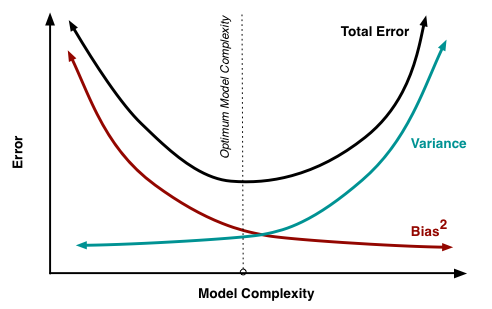

Source: https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html

- **Bias** is the simplifying assumptions made by a model to make the target function easier to learn. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).

- **Variance** is the amount that the estimate of the target function will change if different training data was used. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

The tradeoff:

- If a model is too simple and has very few parameters then it may have high bias and low variance. On the other hand, if a model has a large number of parameters then it’s going to have high variance and low bias. So, we need to find the right/good balance without overfitting and underfitting the data.

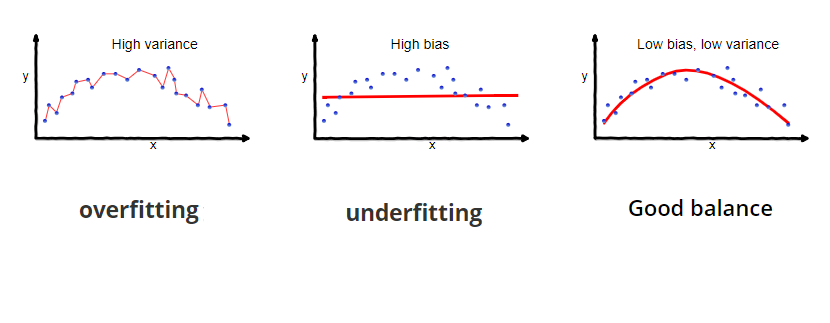

Source: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

- This tradeoff in complexity is why there is a tradeoff between bias and variance. An algorithm can’t be more complex and less complex at the same time.

Why is it important?

- Understanding the Bias-Variance Tradeoff is important for understanding the behavior of prediction models. You need to understand this tradeoff to properly diagnose the problems with your models.

- It's a fundamental topic that can guide you in selecting the right model complexity, the right training set size, and the right balance between under- and overfitting.



## 1.3 Automatic backward elimination

Here we use a loop to automatically remove features by the backward elimination algorithm
- Try change the significance level to see how it changes the result

Removing variable: year with p-value: 0.9060459507279626
Removing variable: thinness_5_9_years with p-value: 0.7786524208873806
Removing variable: population with p-value: 0.6950372656186445
Removing variable: percentage_expenditure with p-value: 0.3908454014139615
Removing variable: total_expenditure with p-value: 0.3115786173651681
Removing variable: alcohol with p-value: 0.03204800237252277
Removing variable: measles with p-value: 0.0073100876304557005
Removing variable: thinness_1_19_years with p-value: 0.00026481753957966115
Removing variable: hepatitis_b with p-value: 1.4726878804029226e-05
Removing variable: polio with p-value: 8.346790984975658e-07
No variable has a p-value over the significance level.
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-s

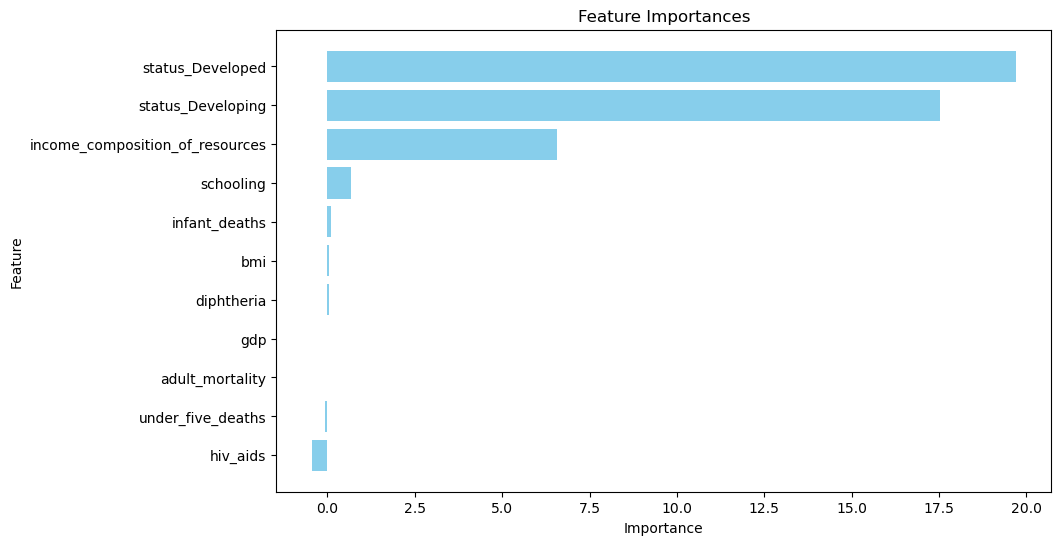

Selected features: Index(['adult_mortality', 'infant_deaths', 'bmi', 'under_five_deaths',
       'diphtheria', 'hiv_aids', 'gdp', 'income_composition_of_resources',
       'schooling', 'status_Developed', 'status_Developing'],
      dtype='object')


In [35]:
# Data Prep
#===================================

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Linear Regression model using statsmodels
#============================================

# Define significance level
significance_level = 0.05

# Perform the linear regression with backward elimination
while True:
    # Add a constant term to the independent variable
    model_sm = sm.OLS(y_train, sm.add_constant(X_train))
    result = model_sm.fit()

    # Get the summary table
    summary_table = result.summary2().tables[1]

    # Get the variable with the highest p-value
    highest_pvalue_variable = summary_table['P>|t|'].idxmax()
    highest_pvalue = summary_table['P>|t|'].max()

    # Check if the highest p-value is over the significance level
    if highest_pvalue > significance_level:
        print(f"Removing variable: {highest_pvalue_variable} with p-value: {highest_pvalue}")
        # Remove the variable with the highest p-value
        if highest_pvalue_variable == 'const':
            print("The model's constant has a p-value over the significance level.")
            break
        else:
            X_train = X_train.drop(columns=highest_pvalue_variable)
            X_test = X_test.drop(columns=highest_pvalue_variable)
    else:
        print("No variable has a p-value over the significance level.")
        break

# Make predictions
y_pred_sm = result.predict(sm.add_constant(X_test))

# Print out the statistics
print(result.summary())

# Calculate validation metrics using our custom function:
calculate_metrics(y_test, y_pred_sm)

# Plot feature importances using our custom function:
plot_feature_importances(result)

# Print resulting selected features
print('Selected features:', X_train.columns)

## 1.4 Automatic forward-selection

Here we use a loop to automatically remove features by the forward-selection algorithm
- Try change the significance level to see how it changes the result

Adding variable: year with p-value: 1.7903262457705266e-17
Adding variable: adult_mortality with p-value: 0.0
Adding variable: infant_deaths with p-value: 5.225181017116729e-22
Adding variable: alcohol with p-value: 8.093929646503404e-77
Adding variable: percentage_expenditure with p-value: 1.7420432349895395e-23
Adding variable: hepatitis_b with p-value: 1.6187155858057275e-06
Adding variable: measles with p-value: 1.5837263929625227e-09
Adding variable: bmi with p-value: 5.3966249545414895e-59
Adding variable: under_five_deaths with p-value: 5.943877714034337e-48
Adding variable: polio with p-value: 4.456850841870995e-32
Skipping variable: total_expenditure with p-value: 0.5621331602968086
Adding variable: diphtheria with p-value: 7.572606507460813e-17
Adding variable: hiv_aids with p-value: 1.2296163437937871e-87
Adding variable: gdp with p-value: 8.146786521827871e-07
Skipping variable: population with p-value: 0.6303697275240965
Adding variable: thinness_1_19_years with p-value: 1

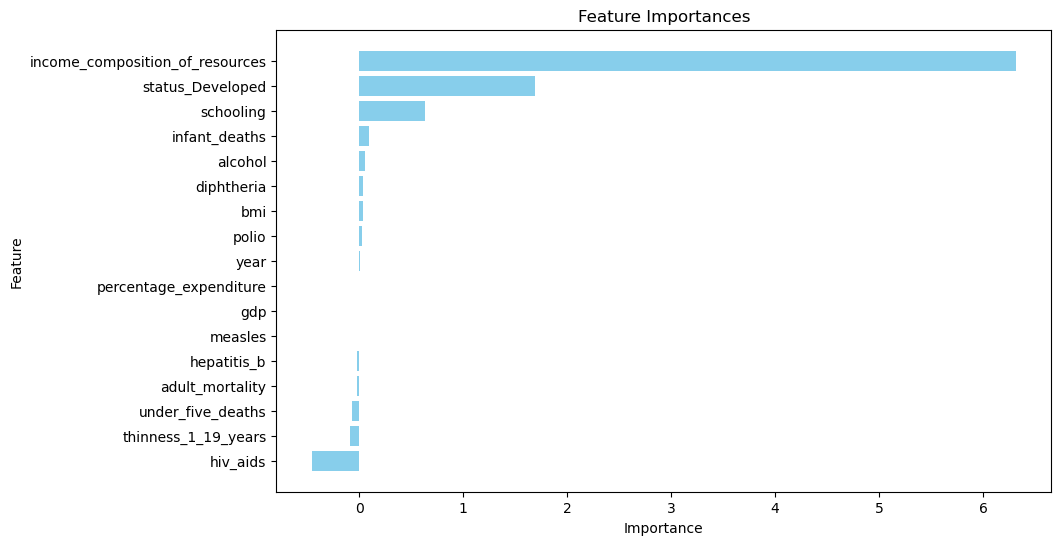

Selected features: ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp', 'thinness_1_19_years', 'income_composition_of_resources', 'schooling', 'status_Developed']


In [37]:
# Data Prep
#===================================

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Linear Regression model using statsmodels
#============================================

# Define significance level
significance_level = 0.05

# Initialize selected features
selected_features = []

# Perform the linear regression with forward selection
for feature in X_train.columns:
    # Add a constant term to the independent variable
    X_train_temp = sm.add_constant(X_train[selected_features + [feature]])
    model_sm = sm.OLS(y_train, X_train_temp)
    result = model_sm.fit()

    # Get the summary table
    summary_table = result.summary2().tables[1]

    # Get the p-value of the added feature
    pvalue = summary_table.loc[feature, 'P>|t|']

    # Check if the p-value is under the significance level
    if pvalue < significance_level:
        print(f"Adding variable: {feature} with p-value: {pvalue}")
        # Add the variable to the selected features
        selected_features.append(feature)
    else:
        print(f"Skipping variable: {feature} with p-value: {pvalue}")

# Fit the model with the selected features
X_train_selected = sm.add_constant(X_train[selected_features])
model_sm = sm.OLS(y_train, X_train_selected)
result = model_sm.fit()

# Make predictions
X_test_selected = sm.add_constant(X_test[selected_features])
y_pred_sm = result.predict(X_test_selected)

# Print out the statistics
print(result.summary())

# Calculate validation metrics using our custom function:
calculate_metrics(y_test, y_pred_sm)

# Plot feature importances using our custom function:
plot_feature_importances(result)

# Print resulting selected features
print('Selected features:', selected_features)

# 2. Ridge Regression

Ridge Regression is a measure used for handling multicollinearity in multiple regression data. Multicollinearity arises when predictor variables are highly correlated, leading to unstable and unreliable estimates of regression coefficients.

Ridge Regression mitigates this by introducing a slight bias into the regression estimates, thereby reducing the standard errors. It's a variant of linear regression that utilises L2 regularisation. 

Here's a more detailed explanation:

- Ridge Regression introduces a small bias into the regression coefficients, which in turn reduces the variance of the estimates. This bias-variance trade-off results in improved prediction accuracy.

- The degree of bias introduced is controlled by a tuning parameter, often referred to as `lambda` or `alpha`. When this parameter is zero, Ridge Regression is equivalent to Linear Regression. When it's greater than zero, all coefficients are shrunk towards zero.

- The `alpha` parameter is set prior to fitting the model. It's typically chosen through a process known as cross-validation.

Why use Ridge Regression?

- It's beneficial when dealing with features that are highly correlated (multicollinearity).

- It aids in preventing overfitting, a modelling error that occurs when a function is too closely fit to a limited set of data points.

- It's computationally as efficient as ordinary least squares.

- It performs well even when the number of variables exceeds the number of observations.

However, Ridge Regression doesn't eliminate irrelevant features but rather minimises their impact. If feature selection is of paramount importance, other techniques such as Lasso or Elastic Net might be more suitable.

c:\Users\hjurz\.conda\envs\env_regression\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81501e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


MAE: 2.86
MSE: 15.23
RMSE: 3.9
R-squared: 0.824


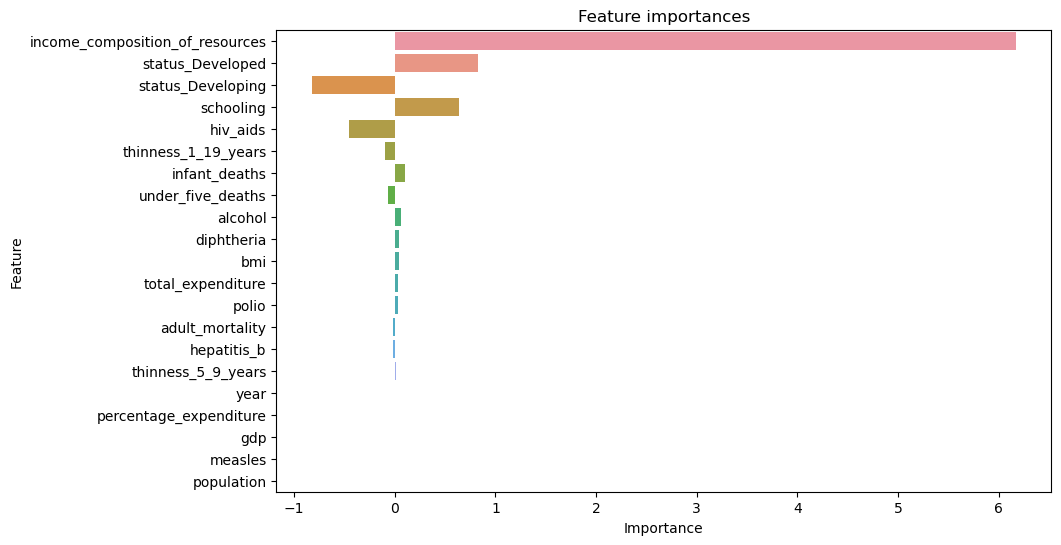

In [30]:
from sklearn.linear_model import Ridge

# Data Prep
#===================================

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Ridge Regression model using scikit-learn
#============================================

# Perform the ridge regression
# Initialize the Ridge model
model_ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter as needed

# Fit the model
model_ridge.fit(X_train, y_train)

# Make predictions
y_pred_ridge = model_ridge.predict(X_test)

# Calculate validation metrics using our custom function:
calculate_metrics(y_test, y_pred_ridge)

# # Plot feature importances using our custom function:
plot_feature_importances2(model_ridge)

# 3. Lasso Regression

Lasso Regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. This is particularly useful in the context of high-dimensional datasets where some features might not be relevant.

Here's how it works:

- Lasso Regression not only helps in reducing over-fitting but it can help us in feature selection. Unlike Ridge Regression, the Lasso does both parameter shrinkage and variable selection automatically because it forces the sum of the absolute value of the regression coefficients to be less than a fixed value, which forces certain coefficients to be set to zero, effectively choosing a simpler model that does not include those coefficients.

- This property of Lasso Regression is known as sparsity. Sparsity can be a very desirable quality when dealing with high-dimensional data with many features, as a sparse solution is easier to interpret.

- The amount of sparsity can be controlled by the tuning parameter, `lambda` or `alpha`. When `alpha` is zero, Lasso Regression produces the same coefficients as a Linear Regression. For `alpha` greater than zero, the amount of shrinkage increases.

Why use Lasso Regression?

- It's useful when you want to automatically perform feature selection, as it forces some coefficients to be exactly zero.

- It helps to prevent overfitting, a modelling error that occurs when a function is too closely fit to a limited set of data points.

- It's computationally just as fast as ordinary least squares, although it requires tuning of the `alpha` parameter.

Remember, Lasso Regression can lead to underfitting if `alpha` is set too high. This is because too many features are ignored by setting their coefficients to zero. If feature selection is not a priority and you have a lot of features, Ridge or Elastic Net might be better choices.

c:\Users\hjurz\.conda\envs\env_regression\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e+04, tolerance: 2.145e+01
  model = cd_fast.enet_coordinate_descent(


MAE: 2.9
MSE: 15.88
RMSE: 3.99
R-squared: 0.817


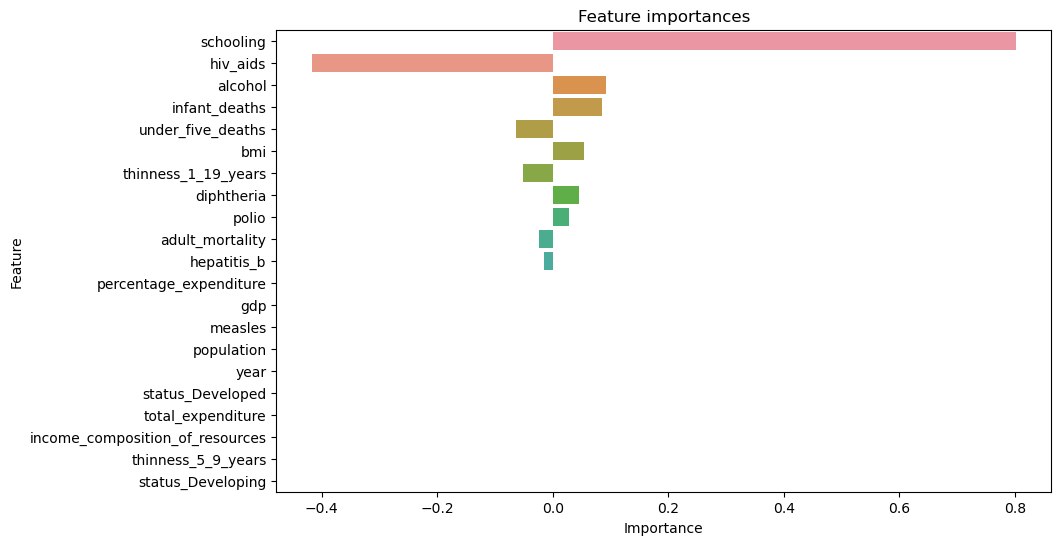

In [31]:
from sklearn.linear_model import Lasso

# Data Prep
#===================================

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Lasso Regression model using scikit-learn
#============================================

# Perform the lasso regression
# Initialize the Lasso model
model_lasso = Lasso(alpha=1.0)  # You can adjust the alpha parameter as needed

# Fit the model
model_lasso.fit(X_train, y_train)

# Make predictions
y_pred_lasso = model_lasso.predict(X_test)

# Calculate validation metrics using our custom function:
calculate_metrics(y_test, y_pred_lasso)

# Plot feature importances using our custom function:
plot_feature_importances2(model_lasso)

# 4.0 Elastic Net

Elastic Net Regression is a middle ground between Ridge Regression and Lasso Regression. It's a regularised regression method that linearly combines the L1 and L2 penalties of the Lasso and Ridge methods.

Here's how it works:

- Elastic Net is useful when there are multiple features which are correlated. Lasso is likely to pick one of these at random, while Elastic Net is likely to pick both.

- A practical advantage of trading-off between Lasso and Ridge is that it allows Elastic Net to inherit some of Ridge’s stability under rotation.

- The mixing parameter `l1_ratio` controls the balance between adding the L1 and L2 penalties. `l1_ratio=0` corresponds to Ridge, and `l1_ratio=1` to Lasso.

Why use Elastic Net?

- It's useful when we have a bunch of features which are correlated. Lasso might just select one of them randomly, Elastic Net is likely to select both.

- It allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularisation properties of Ridge.

- Elastic-net is useful when there are multiple correlated features.

Remember, like Lasso and Ridge, Elastic Net also requires tuning of its parameters. If feature selection is not a priority and you have a lot of features, Ridge might be a better choice. If you want a sparse solution, you can use Lasso or adjust the `l1_ratio` of Elastic Net.

c:\Users\hjurz\.conda\envs\env_regression\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+04, tolerance: 2.145e+01
  model = cd_fast.enet_coordinate_descent(


MAE: 2.9
MSE: 15.77
RMSE: 3.97
R-squared: 0.818


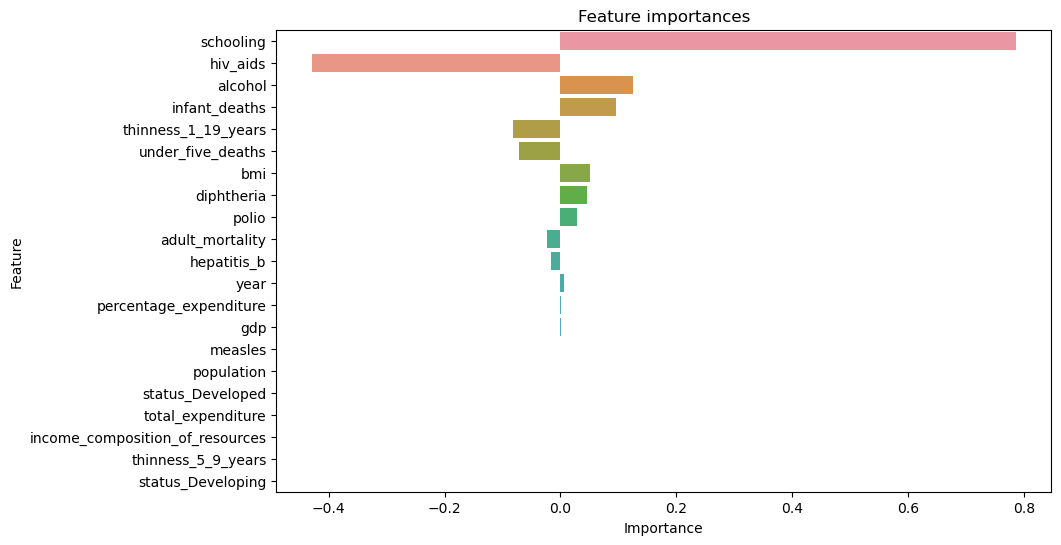

In [32]:
from sklearn.linear_model import ElasticNet

# Data Prep
#===================================

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(
    df=df, 
    feature_variables=feature_variables, 
    target_variable=target_variable
    )

# Elastic Net Regression model using scikit-learn
#============================================

# Perform the elastic net regression
# Initialize the Elastic Net model
model_enet = ElasticNet(alpha=1.0, l1_ratio=0.5)  # You can adjust the alpha and l1_ratio parameters as needed

# Fit the model
model_enet.fit(X_train, y_train)

# Make predictions
y_pred_enet = model_enet.predict(X_test)

# Calculate validation metrics using our custom function:
calculate_metrics(y_test, y_pred_enet)

# Plot feature importances using our custom function:
plot_feature_importances2(model_enet)